# 基于 Word2Vec 和 PCA 的人物关系可视化

本项目旨在通过自然语言处理技术（NLP），分析小说中的人物关系，并利用降维技术（PCA）对人物进行可视化。具体步骤包括：
1. **数据预处理**：读取小说文本并提取人名。
2. **词频统计**：计算每个人物在文本中的出现频率。
3. **Word2Vec 模型训练**：生成人物的词向量表示。
4. **PCA 降维**：将高维词向量降维至二维或三维空间。
5. **可视化**：绘制二维和三维散点图，并生成交互式 HTML 文件。

最终目标是生成以下文件：
- 所有人物的二维和三维图。
- 前 50 个核心人物的二维和三维图。
- 关键人物及其相关人物的二维和三维图。
- 包含所有人的二维和三维交互式 HTML 文件。

**导入相关库**

In [18]:
import os
import jieba
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import plotly.express as px
from collections import Counter

**设置图片显示的字体**

In [19]:
# 设置字体为SimHei，以支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

**读取小说文本**

In [20]:
# 读取所有小说文本
def read_novels(directory):
    all_text = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            try:
                with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                    all_text.append(file.read())
            except UnicodeDecodeError:
                with open(os.path.join(directory, filename), 'r', encoding='GBK') as file:
                    all_text.append(file.read())
    return all_text


**统计人名词频**

In [21]:
# 统计人名的词频
def count_name_frequencies(texts, names):
    name_counts = Counter()
    for text in texts:
        words = list(jieba.cut(text))  # 分词
        for word in words:
            if word in names:
                name_counts[word] += 1
    return name_counts

## Word2Vec 模型训练

使用 `gensim` 库的 `Word2Vec` 模型对小说文本进行训练，生成人物的词向量表示。  
- **分词**：使用 `jieba` 对文本进行分词。
- **参数设置**：
  - 向量维度：100
  - 窗口大小：5
  - 最小词频：1
- **输出**：每个人物对应的高维词向量。

这些词向量捕捉了人物之间的语义关系，为后续的降维和可视化提供了数据支持。

In [22]:
# 训练word2vec模型
def train_word2vec(texts, vector_size=200, window=10, min_count=5, workers=4):
    sentences = [list(jieba.cut(text)) for text in texts]  # 使用jieba进行分词
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    return model

**获取人名的embedding**

In [23]:
# 获取人名的embedding
def get_name_embeddings(model, names):
    embeddings = []
    valid_names = []
    for name in names:
        if name in model.wv:
            embeddings.append(model.wv[name])
            valid_names.append(name)
    return embeddings, valid_names

**PCA降维**

In [24]:
# PCA降维
def reduce_dimensions(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

**找到与关键人物最相关的人物**

In [25]:
# 找到与关键人物最相关的人物
def find_related_characters(model, key_character, num_related=10):
    if key_character not in model.wv:
        raise ValueError(f"Key character '{key_character}' not found in the model.")
    related_characters = model.wv.most_similar(key_character, topn=num_related)
    return [name for name, _ in related_characters]


**绘制二维图**

In [26]:
# 绘制二维图
def plot_2d(reduced_embeddings, names, title="PCA of Names (2D)", output_path=None):
    plt.figure(figsize=(10, 8))
    for i, name in enumerate(names):
        x, y = reduced_embeddings[i]
        plt.scatter(x, y)
        plt.text(x, y, name, fontsize=9, ha='right', va='bottom')  # 在点旁边添加名字
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout()  # 自动调整布局，避免标签重叠
    if output_path:
        plt.savefig(output_path, dpi=300)  # 保存为高分辨率图片
    plt.show()

**绘制三维图**

In [27]:
# 绘制三维图
def plot_3d(reduced_embeddings, names, title="PCA of Names (3D)", output_path=None):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i, name in enumerate(names):
        x, y, z = reduced_embeddings[i]
        ax.scatter(x, y, z)
        ax.text(x, y, z, name, fontsize=9)  # 在点旁边添加名字
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.tight_layout()  # 自动调整布局
    if output_path:
        plt.savefig(output_path, dpi=300)  # 保存为高分辨率图片
    plt.show()

**生成包含所有人的HTML文件（二维）**

In [28]:
# 生成包含所有人的HTML文件（二维）
def generate_html_2d_visualization(embeddings_all, names_all, output_html_path):
    df_all = pd.DataFrame(embeddings_all, columns=['x', 'y'])
    df_all['name'] = names_all
    fig = px.scatter(df_all, x='x', y='y', text='name', title="PCA of All Names (2D)")
    fig.update_traces(textposition='top center')
    fig.write_html(output_html_path)  # 保存为HTML文件

**生成包含所有人的HTML文件（三维）**

In [29]:
# 生成包含所有人的HTML文件（三维）
def generate_html_3d_visualization(embeddings_all, names_all, output_html_path):
    df_all = pd.DataFrame(embeddings_all, columns=['x', 'y', 'z'])
    df_all['name'] = names_all
    fig = px.scatter_3d(df_all, x='x', y='y', z='z', text='name', title="PCA of All Names (3D)")
    fig.update_traces(textposition='top center')
    fig.write_html(output_html_path)  # 保存为HTML文件


**主程序**

In [30]:
# 主程序
if __name__ == "__main__":
    novels_directory = 'D:\\桌面\\word2vec\\data\\data'  # 小说文件夹路径
    names_file = 'D:\\桌面\\word2vec\\人名.txt'  # 人名文件路径

    # 读取小说文本
    print("正在加载小说文本...")
    novels = read_novels(novels_directory)
    print(f"共加载了 {len(novels)} 本小说文本。")

    # 读取人名
    print("正在加载人名列表...")
    with open(names_file, 'r', encoding='utf-8') as file:
        names = [line.strip() for line in file.readlines()]
    print(f"共加载了 {len(names)} 个人名。")

    # 统计人名的词频
    print("正在统计人名词频...")
    name_counts = count_name_frequencies(novels, names)
    print(f"前10个高频人名：{name_counts.most_common(10)}")

    # 训练word2vec模型
    print("正在训练Word2Vec模型...")
    model = train_word2vec(novels, vector_size=200, window=10, min_count=5, workers=4)
    print(f"Word2Vec模型训练完成，词向量维度为 {model.vector_size}。")


正在加载小说文本...
共加载了 16 本小说文本。
正在加载人名列表...
共加载了 1373 个人名。
正在统计人名词频...
前10个高频人名：[('韦小宝', 9920), ('令狐冲', 5052), ('杨过', 4851), ('张无忌', 4786), ('郭靖', 3583), ('袁承志', 2672), ('黄蓉', 2638), ('小龙女', 2256), ('陈家洛', 2192), ('段誉', 2017)]
正在训练Word2Vec模型...
Word2Vec模型训练完成，词向量维度为 200。


正在获取人名的嵌入向量...
共有 1140 个人名具有有效的嵌入向量。
正在进行PCA降维（2D）...
已完成PCA降维（2D）。


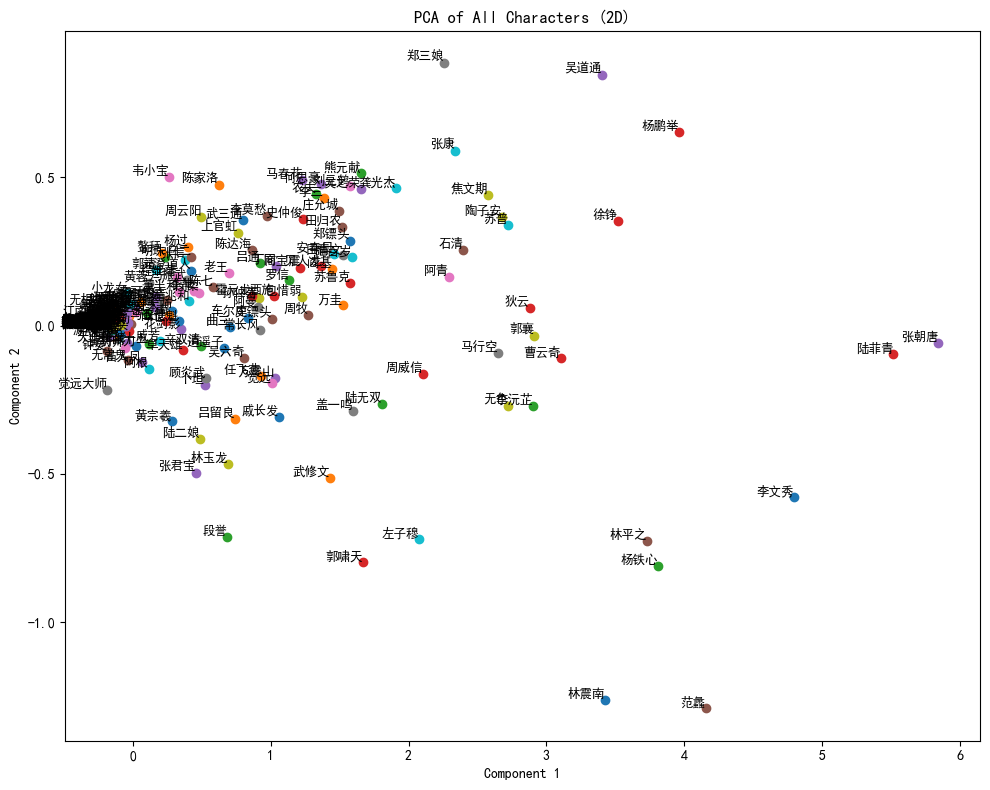

正在进行PCA降维（3D）...
已完成PCA降维（3D）。


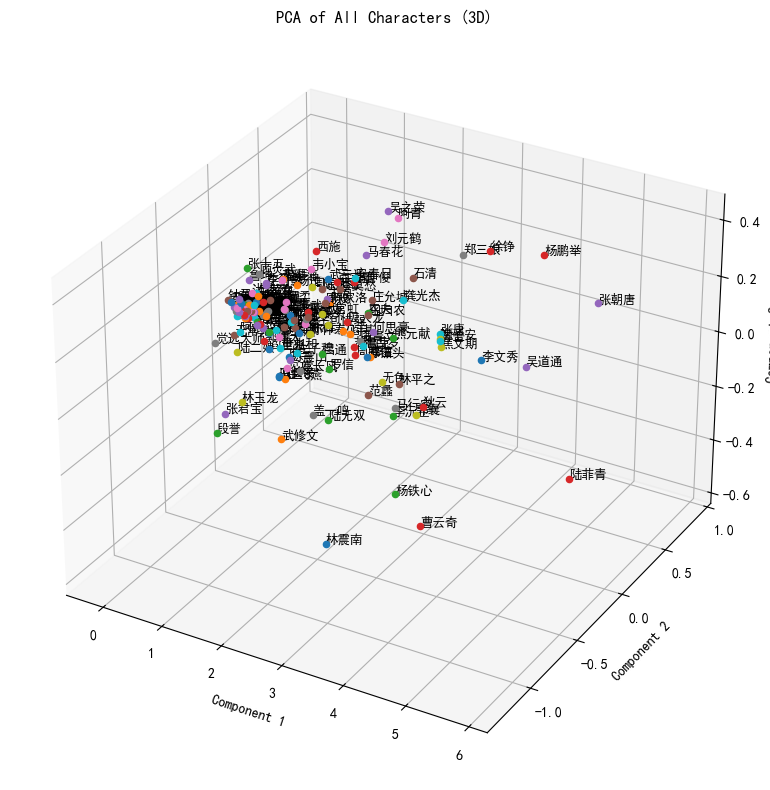

In [31]:
# 获取所有人名的embedding
print("正在获取人名的嵌入向量...")
all_embeddings, valid_all_names = get_name_embeddings(model, names)
print(f"共有 {len(valid_all_names)} 个人名具有有效的嵌入向量。")

# PCA降维到2D（所有人物）
print("正在进行PCA降维（2D）...")
reduced_embeddings_all_2d = reduce_dimensions(all_embeddings, n_components=2)
print("已完成PCA降维（2D）。")
plot_2d(reduced_embeddings_all_2d, valid_all_names, title="PCA of All Characters (2D)", output_path='pca_all_2d.png')

# PCA降维到3D（所有人物）
print("正在进行PCA降维（3D）...")
reduced_embeddings_all_3d = reduce_dimensions(all_embeddings, n_components=3)
print("已完成PCA降维（3D）。")
plot_3d(reduced_embeddings_all_3d, valid_all_names, title="PCA of All Characters (3D)", output_path='pca_all_3d.png')

In [32]:
# 生成包含所有人的HTML文件（二维）
print("正在生成包含所有人的二维HTML文件...")
generate_html_2d_visualization(reduced_embeddings_all_2d, valid_all_names, output_html_path='pca_all_names_2d.html')
print("已生成二维HTML文件：pca_all_names_2d.html")

# 生成包含所有人的HTML文件（三维）
print("正在生成包含所有人的三维HTML文件...")
generate_html_3d_visualization(reduced_embeddings_all_3d, valid_all_names, output_html_path='pca_all_names_3d.html')
print("已生成三维HTML文件：pca_all_names_3d.html")

正在生成包含所有人的二维HTML文件...
已生成二维HTML文件：pca_all_names_2d.html
正在生成包含所有人的三维HTML文件...
已生成三维HTML文件：pca_all_names_3d.html


正在筛选前50个核心人物...
筛选后的前50个核心人物：['韦小宝', '令狐冲', '杨过', '张无忌', '郭靖', '袁承志', '黄蓉', '小龙女', '陈家洛', '段誉', '石破天', '胡斐', '虚竹', '萧峰', '洪七公', '周伯通', '国师', '岳不群', '黄药师', '张翠山', '李莫愁', '谢逊', '吴三桂', '乔峰', '林平之', '岳灵珊', '王语嫣', '赵敏', '慕容复', '周芷若', '程灵素', '狄云', '段正淳', '张召重', '木婉清', '田伯光', '徐天宏', '仪琳', '双儿', '霍青桐', '文泰来', '鸠摩智', '余鱼同', '柯镇恶', '郭襄', '姑姑', '殷素素', '陆无双', '阿朱', '向问天']
正在进行PCA降维（2D，前50个核心人物）...


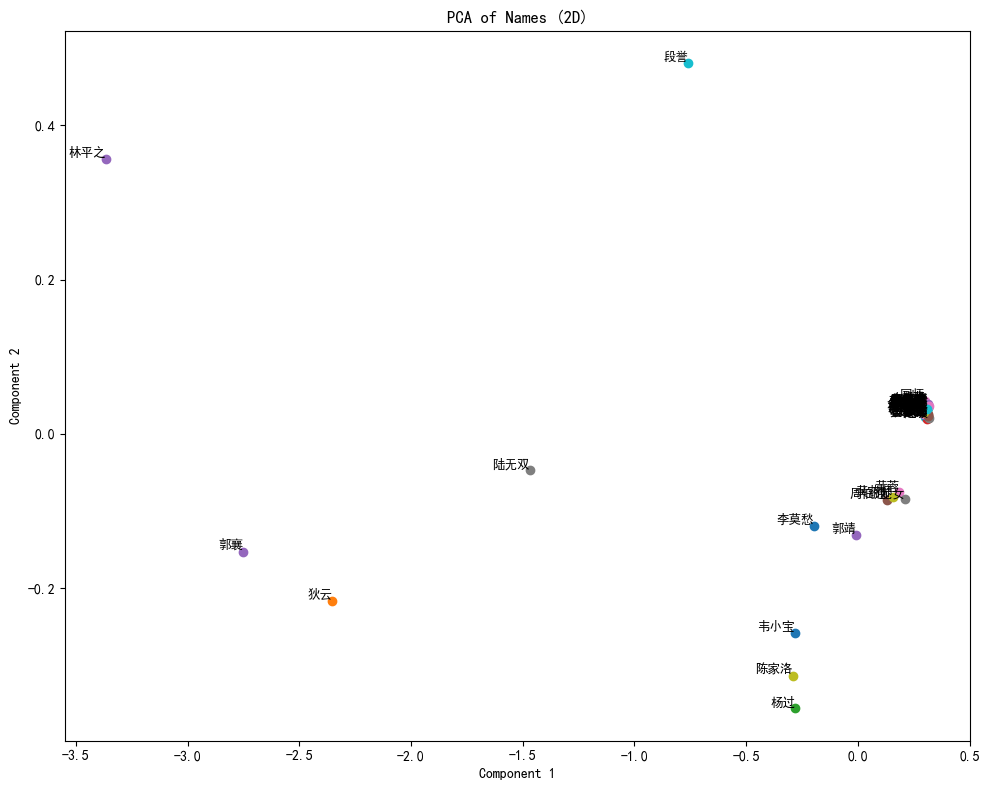

正在进行PCA降维（3D，前50个核心人物）...


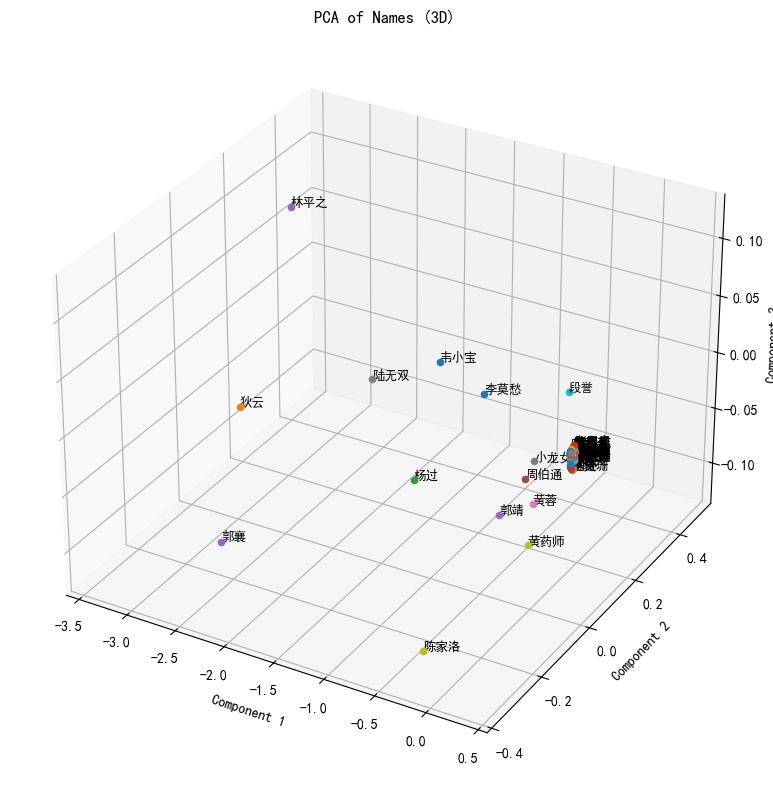

正在查找与关键人物 '郭靖' 最相关的若干个人物...
与 '郭靖' 最相关的若干个人物：['杨康', '黄蓉', '郭靖', '朱聪', '梅超风', '韩小莹', '洪七公', '穆念慈']
正在进行PCA降维（2D，关键人物及其相关人物）...


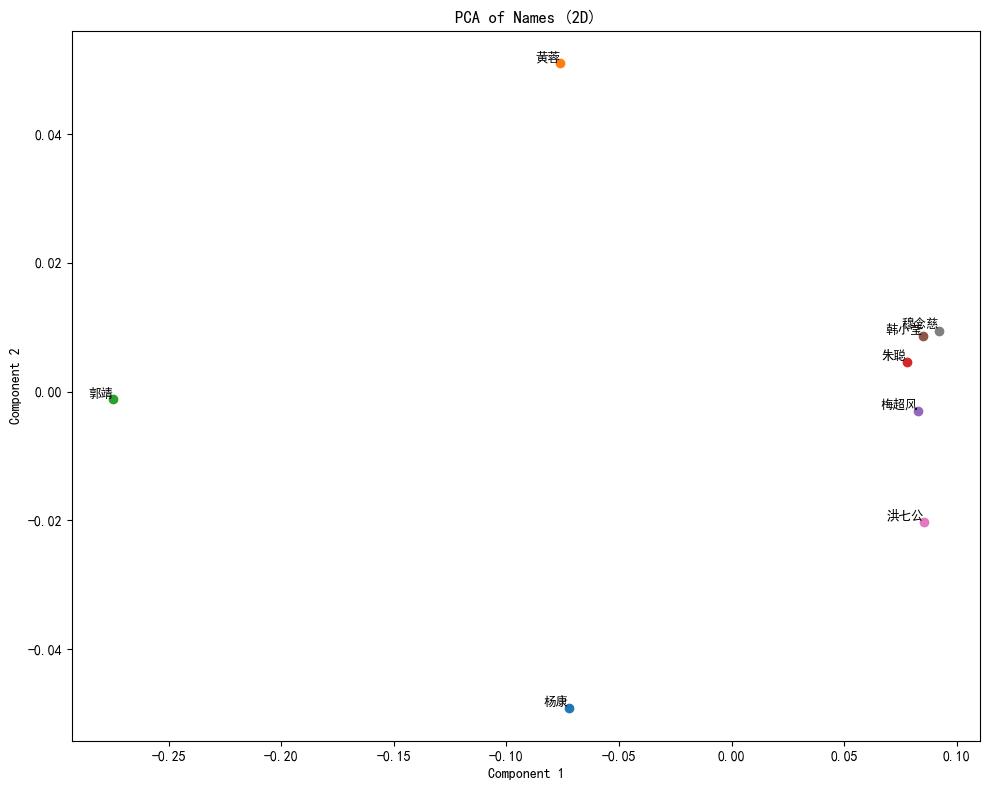

正在进行PCA降维（3D，关键人物及其相关人物）...


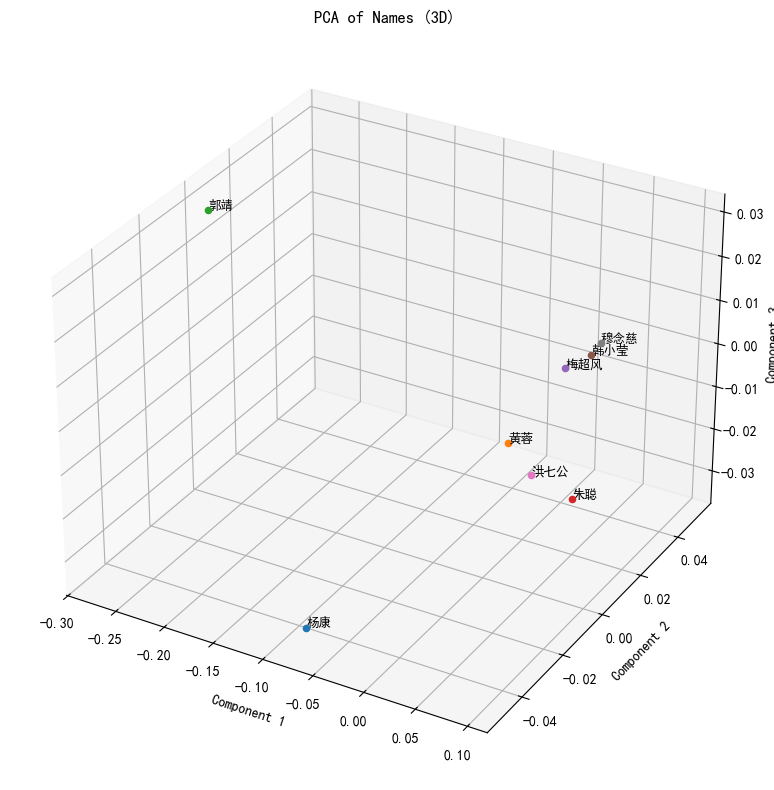

In [43]:
# 按词频排序，选择前 N 个核心人物
print("正在筛选前50个核心人物...")
num_core_characters = 50  # 选择前 50 个核心人物
core_characters = [name for name, _ in name_counts.most_common(num_core_characters)]

# 过滤掉不在 valid_all_names 中的核心人物
core_characters = [name for name in core_characters if name in valid_all_names]
print(f"筛选后的前50个核心人物：{core_characters}")

# 获取核心人物的embedding
core_embeddings, valid_core_characters = get_name_embeddings(model, core_characters)

# PCA降维到2D（核心人物）
print("正在进行PCA降维（2D，前50个核心人物）...")
reduced_embeddings_core_2d = reduce_dimensions(core_embeddings, n_components=2)
plot_2d(reduced_embeddings_core_2d, valid_core_characters, output_path='pca_top50_2d.png')

# PCA降维到3D（核心人物）
print("正在进行PCA降维（3D，前50个核心人物）...")
reduced_embeddings_core_3d = reduce_dimensions(core_embeddings, n_components=3)
plot_3d(reduced_embeddings_core_3d, valid_core_characters, output_path='pca_top50_3d.png')

# 选择关键人物（例如“郭靖”），并找到与其最相关的人物
key_character = "郭靖"
print(f"正在查找与关键人物 '{key_character}' 最相关的若干个人物...")

# 自动寻找相关人物
related_characters = [name for name, _ in model.wv.most_similar(key_character, topn=10)]

# 手动补充重要人物（确保相关人物是人名）
manual_related_characters = ["黄蓉", "杨康", "穆念慈", "洪七公", "欧阳锋", "梅超风", "段智兴", "南希奴", "朱聪", "韩小莹"]
related_characters = list(set(related_characters + manual_related_characters + [key_character]))

# 过滤掉非人名的词汇
filtered_related_characters = [name for name in related_characters if name in valid_all_names]
print(f"与 '{key_character}' 最相关的若干个人物：{filtered_related_characters}")

# 获取关键人物及其相关人物的embedding
related_embeddings, valid_related_names = get_name_embeddings(model, filtered_related_characters)

# PCA降维到2D（关键人物及其相关人物）
print("正在进行PCA降维（2D，关键人物及其相关人物）...")
reduced_embeddings_related_2d = reduce_dimensions(related_embeddings, n_components=2)
plot_2d(reduced_embeddings_related_2d, valid_related_names, output_path=f'pca_{key_character}_2d.png')

# PCA降维到3D（关键人物及其相关人物）
print("正在进行PCA降维（3D，关键人物及其相关人物）...")
reduced_embeddings_related_3d = reduce_dimensions(related_embeddings, n_components=3)
plot_3d(reduced_embeddings_related_3d, valid_related_names, output_path=f'pca_{key_character}_3d.png')

# 整体情况

## 数据预处理

这部分完成以下任务：
1. **读取小说文本**：从指定目录加载所有小说文本文件。
2. **提取人名**：从文本中提取有效的人名列表。
3. **统计词频**：计算每个人物在文本中的出现次数，用于筛选核心人物。

这些步骤为后续模型训练和可视化奠定了基础。

## Word2Vec 模型训练

使用 `gensim` 库的 `Word2Vec` 模型对小说文本进行训练，生成人物的词向量表示。  
- **分词**：使用 `jieba` 对文本进行分词。
- **参数设置**：
  - 向量维度：100
  - 窗口大小：5
  - 最小词频：1
- **输出**：每个人物对应的高维词向量。

这些词向量捕捉了人物之间的语义关系，为后续的降维和可视化提供了数据支持。

## 核心人物筛选与 PCA 降维

### 核心人物筛选
根据词频统计结果，选择前 50 个高频人物作为核心人物。  
- **过滤无效名字**：确保选出的核心人物在 Word2Vec 模型中有有效的嵌入向量。

### PCA 降维
使用 `sklearn` 的 `PCA` 方法将高维词向量降维至二维和三维空间。  
- **降维目的**：便于可视化人物之间的关系。
- **输出**：
  - 前 50 个核心人物的二维和三维图。
  - 图表保存为 PNG 文件（`pca_top50_2d.png` 和 `pca_top50_3d.png`）。

## 关键人物相关人物分析

选择关键人物（如“郭靖”），分析与其最相关的若干个人物。  
1. **自动寻找相关人物**：利用 Word2Vec 的 `most_similar` 方法找到与关键人物最相似的人物。
2. **手动补充重要人物**：补充一些重要但可能未被自动识别的人物。
3. **过滤无效名字**：确保所有相关人物在模型中有有效的嵌入向量。

### 可视化
对关键人物及其相关人物进行 PCA 降维，并生成二维和三维图。  
- 图表保存为 PNG 文件（`pca_郭靖_2d.png` 和 `pca_郭靖_3d.png`）。
  
## 全体人物的二维和三维可视化

对所有人名进行 PCA 降维，并生成二维和三维图。  
- **降维方法**：使用 PCA 将高维词向量降维至二维和三维空间。
- **图表保存**：
  - 二维图：`pca_all_2d.png`
  - 三维图：`pca_all_3d.png`

此外，使用 `Plotly` 生成交互式 HTML 文件，便于用户缩放、旋转和查看详细信息。  
- **HTML 文件**：
  - 二维交互图：`pca_all_names_2d.html`
  - 三维交互图：`pca_all_names_3d.html`

## 总结

通过本项目，我们完成了以下任务：
1. 提取小说中的人物并统计词频。
2. 训练 Word2Vec 模型生成人物的词向量。
3. 使用 PCA 降维技术对人物关系进行可视化。
4. 生成了多个二维和三维图以及交互式 HTML 文件。

这些可视化结果可以帮助我们直观地理解小说中人物之间的关系，为进一步的文本分析提供支持。